# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

# Notebook 3A. Labelled Dataset - Modelling - Relevant vs Irrelevant

## Introduction

In this notebook I perform basic modelling for the labelled dataset. This notebook consists of the following sections:

* 3.0. Loading the data and perfoming data quality checks. 
* 3.1. Regression preparation. Assigning target variable y. Custom tokenization function is defined. Train and text split is made. 
* 3.2. Vectorization.  Most common words identified.  SMOTE sampling set up due to imbalance in data.
* 3.3. Simple logistic regression. Positive and negative coefficients for word tokens. 
* 3.4. Gridsearch for the best logistic regression model. 
* 3.5. Decision Tree Classifier
* 3.6. VADER sentiment analyser.
* 3.7. Textblob from NLTK
* 3.8. Conclusions

## 3.0 Data loading and data quality checks

In [1]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD

# Pipeline Utilities
from sklearn.pipeline import Pipeline, make_pipeline

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

# Serialization/Deserialization Libraries
from joblib import dump
import dill as pickle

import warnings
warnings.filterwarnings("ignore")

# Set the global font to be used for all text
plt.rcParams['font.family'] = 'Gill Sans'  

In [2]:
DATAFILE = '../data/02_labelled_dataset_cleaned.csv'
df1 = pd.read_csv(DATAFILE)

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link_id     4996 non-null   object
 1   parent_id   4996 non-null   object
 2   User        4996 non-null   object
 3   Text        4996 non-null   object
 4   Intent      4996 non-null   object
 5   Support     4996 non-null   object
 6   word_count  4996 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 273.3+ KB


In [4]:
df1=df1.drop(columns=['parent_id', 'User', "Support",'word_count']) #"emoji_text"])

In [5]:
# Rename the 'link_id' column to 'id'
df1 = df1.rename(columns={'link_id': 'id'})

In [6]:
df1.duplicated().sum()

3

In [7]:
# Remove duplicate rows
df1 = df1.drop_duplicates()

In [8]:
DATAFILE2 = '../data/reddit_gpt4_negative_only_cleaned.csv'
df2 = pd.read_csv(DATAFILE2)

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               450 non-null    object
 1   title            450 non-null    object
 2   selftext         314 non-null    object
 3   Text             450 non-null    object
 4   token_count      450 non-null    int64 
 5   Sentiment_Tag    450 non-null    object
 6   Sentiment_Tag_2  450 non-null    object
dtypes: int64(1), object(6)
memory usage: 24.7+ KB


In [10]:
df2=df2.drop(columns=['title', 'selftext', 'token_count', 'Sentiment_Tag'])

In [11]:
# Rename the 'Sentiment_Tag_2' column to 'Intent'
df2 = df2.rename(columns={'Sentiment_Tag_2': 'Intent'})

In [12]:
df2.describe()

,id,Text,Intent
count,450,450,450
unique,441,441,1
top,mpbyzf,"4/12/2021 GME Borrowables Alert 7.30am, Hey gu...",Negative
freq,2,2,450


In [13]:
df2.duplicated().sum()

9

In [14]:
df2.drop_duplicates()

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative
...,...,...,...
445,msla5l,"Gme going to zero, invest in Broccoli futures ...",Negative
446,ril23c,Hilarious how much msm is pumping popcorn toda...,Negative
447,ncf668,"Maybe they shorted GME, nan",Negative
448,mkm697,Sell Order Rejected 🙅‍♂️- I doubt if your deal...,Negative


In [15]:
df2.head()

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative


In [16]:
# Replace 'Negative' with 'n' in the 'Intent' column
df2['Intent'] = df2['Intent'].replace("Negative", "n")

In [17]:
# Replace 'NaN' and 'nan' with an empty string in the 'Text' column of df2
df2['Text'] = df2['Text'].str.replace('NaN|nan', '', regex=True)

In [18]:
# Concatenate df and df2 vertically
df = pd.concat([df1, df2], ignore_index=True)
df

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y
...,...,...,...
5438,msla5l,"Gme going to zero, invest in Broccoli futures ...",n
5439,ril23c,Hilarious how much msm is pumping popcorn toda...,n
5440,ncf668,"Maybe they shorted GME,",n
5441,mkm697,Sell Order Rejected 🙅‍♂️- I doubt if your deal...,n


In [19]:
df['Intent'].value_counts()

Intent
u    3245
y     983
n     533
m     370
i     312
Name: count, dtype: int64

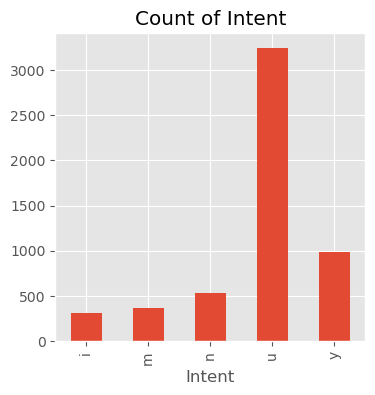

In [20]:
ax = df['Intent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Intent',
          figsize=(4, 4))
ax.set_xlabel('Intent')
plt.show()

* Majority of posts (2/3) received clasification 'u', which means 'uncertain'. 
* 20% of posts were rated as "positive" signalling an intent to buy GME shares.
* Only a very small % of messages were rated as "negative" which creates an  imbalance in our set.  We have a deficit of examples of negative posts. 

## 3.1. Assigning target variable

In [21]:
df.head(5)

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y


In the code below I assign new binary labels to the target variable "Intent".  I experimented with various approaches, for example encoding only "yes" asnwers with 1s, and the rest of teh answers as 0s.  I run all of theclassification models on various combinations of encoding.  The best results are achieved when "yes" and "maybe" categories are encoded as 1s and "uncertain", "informative", and "no" are encoded as 0s.  

In [22]:
# Filter out rows where 'Intent' is 'm', 'i', or 'u'
# df = df[~df['Intent'].isin(['m', 'i', 'u'])]

In [23]:
df = df.copy()

# Two options together
df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'n')  | (df['Intent'] == 'm'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one option
# df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y'),1, 0)

df.head()

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,0
1,t3_ki3745,"Oh GME, you tease!",0
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",0
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,0
4,t3_l9xqem,Just got into $GME @ 220.,1


In [24]:
df['Intent'].value_counts()

Intent
0    3557
1    1886
Name: count, dtype: int64

In [25]:
#df['Support'].value_counts()

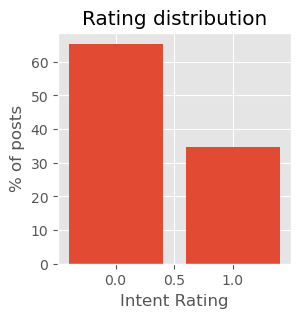

Class imbalance: [0.65 0.35]


In [26]:
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### 2.1.1. Tokenization options

In [27]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'game', 'amc', 'nok', 'bb']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [28]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

#### External popular tokenizers loaded

I want to experiment with a few different tokenizers to see which one works best for my specific project, especially considering the informal and varied nature of social media language. In the code below I download several popular tokenizers used for social media posts, and I will use them in my gridsearch later, to see which one performs better. 

1. spaCy provides a robust and efficient tokenizer that's great for general-purpose text processing. It's particularly good at handling complex and noisy text. spaCy's processing is more sophisticated than simpler tokenization methods, so it is more computationally intensive.

In [29]:
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Tokenizing the document and filtering out punctuation, spaces, and other unwanted tokens
def spacy_tokenizer(document):
    return [token.text for token in nlp(document) if 
            token.is_alpha and  # Keep only alphabetic tokens
            #token.text.lower() not in ["'s", "n't", "’s", "n’t", "’m"] and
            not token.is_punct and 
            not token.is_currency
            ]  # Exclude specific tokens            

# Preprocess each stop word with the tokenizer
processed_stop_words_spacy = set(token for word in stop_words for token in spacy_tokenizer(word))

# Display the processed stop words
print(processed_stop_words_spacy)

{'on', 'm', 'shouldn', 'more', 'when', 'would', 'her', 'you', 'with', 'wasn', 'before', 'how', 'then', 'own', 'amc', 'have', 'hasn', 'did', 'your', 'an', 'ain', 'the', 'yours', 'y', 'shan', 'should', 'll', 'hers', 'any', 'was', 'once', 'both', 'ourselves', 'under', 'don', 'need', 'only', 'doesn', 'by', 'am', 'been', 'same', 'd', 'too', 'this', 'he', 'didn', 'down', 'himself', 'that', 've', 'again', 'hadn', 'being', 'as', 'all', 'haven', 'wo', 'which', 'gme', 'after', 'over', 'other', 'had', 'yourself', 'whom', 'for', 'herself', 'there', 'what', 'does', 'their', 'ma', 'out', 'it', 'up', 'weren', 'above', 'our', 'now', 'or', 's', 'who', 'during', 'below', 'doing', 'will', 'those', 'here', 'themselves', 'until', 'if', 'them', 'might', 'were', 'because', 'isn', 'nok', 'wouldn', 'of', 'i', 'couldn', 'having', 'no', 'mustn', 'each', 'my', 'needn', 'be', 'further', 'myself', 'its', 'between', 'against', 'into', 'such', 'most', 'itself', 'off', 'a', 'to', 'but', 'him', 'where', 'theirs', 'at',

2. TweetTokenizer from NLTK is specifically designed for tokenizing tweets, so it can be effective for Reddit, a similar social media text style. It's good at handling special characters in social media text, like hashtags, mentions, and emojis.

In [30]:
from nltk.tokenize import TweetTokenizer
tokenizer_tweets = TweetTokenizer()

3. BERT's tokenizer handles subword tokenization, and this is usually very useful for social media text with slangs and non-standard words, like Reddit posts in my dataset.  I tried using BERT base model first, but it is not deisgned to handle long text (max 512 token per chunk, whereas the dataset i have has longer posts.  I then tried the Longformer and BigBird transformers model. Longformer was developed by researchers at Allen Institute for AI and is designed for processing long documents by extending the standard Transformer attention mechanism (it can handle sequences up to 4,096 tokens). BigBird was developed at Google, alos can handle up to 4,096 tokens in one sequence, and  

In [31]:
# from transformers import BertTokenizer
# tokenizer_BERT = BertTokenizer.from_pretrained('bert-base-uncased')

# For Longformer
#from transformers import LongformerTokenizer
#tokenizer_longformer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# For BigBird
# from transformers import BigBirdTokenizer
# bigbird_tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')

4. StanfordNLP / Stanza tokenizer was eveloped by Stanford University. It is more resource-intensive than others, but offers state-of-the-art accuracy. I wanted to try that, too, but it was too computationally heavy. 

In [32]:
# import stanza

# Initialize Stanza pipeline
#stanza.download('en')  # Download the English model
#nlp_stanza = stanza.Pipeline(lang='en')

# Define a custom tokenizer using Stanza
#def stanza_tokenizer(text):
#    doc = nlp_stanza(text)
#    return [word.text for sent in doc.sentences for word in sent.words]

### Train test split

In [33]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(4354,)

In [34]:
print(y_test.shape)

(1089,)


## 3.2. Vectorisation 

In [35]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=10, 
                                   ngram_range=(1,2), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

(4354, 1000)


In [36]:
# count the  most common words
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
stock,908
buy,885
share,820
like,677
short,568
get,509
money,494
people,479
go,471
put,471


In [37]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,able,absolutely,access,according,account,action,actual,actually,add,advice,...,x,ya,yeah,year,year ago,yes,yesterday,yet,yolo,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


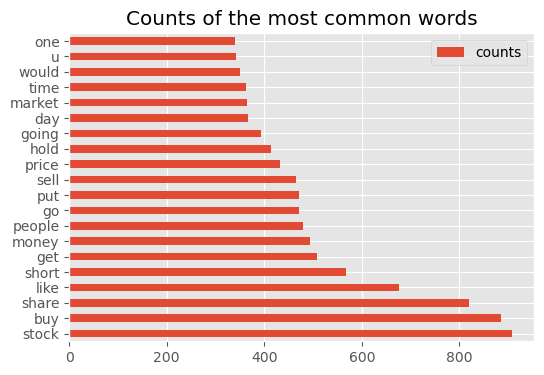

In [38]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

In [39]:
print(word_counts)

            counts
stock          908
buy            885
share          820
like           677
short          568
...            ...
solid           15
usually         15
bagholders      15
totally         14
extra           14

[1000 rows x 1 columns]


**Observations:**

* The list of words assocaited with the messages on wallstreetbets contains a lot of words and combinations of "optimistic" and "super".  This is indicative of a heavy use of the "rocket" and "to the moon!" emojis in that community at the period when the dataset was collected.  In the previous cleaning step I have reworded such slang into plain English using phrase "super optimistic" as a translation. So, the top 4 most frequent words reflect a heavy use of the positive sentiment emojis during that period.
* Other popular words einclude words such as "buy", "share", "stock", "patient"+"investor" (this is a plain English word combination for another emoji, "the diamond hands"), "short", "money", "sell", etc. 
* Overall, the list of words is as expected from a community focused on investments and trading, but the heavy use of positive emojis at the time is clearly visible in the results. 

### SMOTE sampling due to imbalance

* My dataset is imbalanced with only 27% of data being in the positive class. 
* I decided to resample the data it using SMOTE technique (synthetic up-sampling). 
* SMOTE helps to mitigate the bias towards the majority class in an imbalanced dataset by generating synthetic samples for the minority class. 
* I expect better results as this should increase my model's ability to learn from an equally represented dataset, improving its predictive accuracy across all classes.

In [40]:
# instantiate SMOTE sampler, fit it to the training data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_matrix_train, y_train)

In [41]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Intent
0    2845
1    1509
Name: count, dtype: int64


Resampled class distribution


Intent
0    2845
1    2845
Name: count, dtype: int64

In [42]:
# scale the sampled train data and the unsampled test data
# ss_sm = StandardScaler().fit(X_train_sm)
# X_train_sm_ss = ss_sm.transform(X_train_sm)
# X_test_ss = ss_sm.transform(X_test)

## 3.3. Simple Logistic Regression

In [43]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1089, 1000)

In [44]:
logistic_model=LogisticRegression(solver='lbfgs', max_iter=10000) # Also tried  liblinear solver - good for small datasets
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

# Make predictions on the test set
test_predictions = logistic_model.predict(X_matrix_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Train set accuracy 0.85
Test set accuracy 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       712
           1       0.62      0.46      0.53       377

    accuracy                           0.72      1089
   macro avg       0.69      0.66      0.67      1089
weighted avg       0.71      0.72      0.71      1089

Confusion Matrix:
[[607 105]
 [202 175]]


The simple logistic regression model shows a good performance on the training set with an accuracy of 86%. However, the test set accuracy drops to 76%, indicating a potential overfitting to the training data.  I think this is quite understandable given the small dataset I have. 

In terms of precision and recall, the model performs better on the negative class (0s), with a precision of 80% and a recall of 89%. This suggests that it is better at identifying true negatives. For the positive class (1s), the precision is lower at 59%, with a recall of 40%.  The model is less efficient for my target variable, i.e. it is less effective at identifying true intentions to buy and could benefit from further tuning.  I think this is explained by the fact that only 27% of data is in the positive class and not enough training data. 

The overall accuracy of 76% is a decent starting point, but 1) it is not very far away from 73% which is our majority class percentage, and 2) the macro-average and weighted-average scores for precision, recall, and the f1-score are not well balanced between the classes. The f1-score, which balances precision and recall, is significantly higher for the majority negative class (0.85) compared to the positive class (0.48).

The model appears to have room for improvement, especially in correctly predicting the positive class. I will explore more complex models later in this notebook.

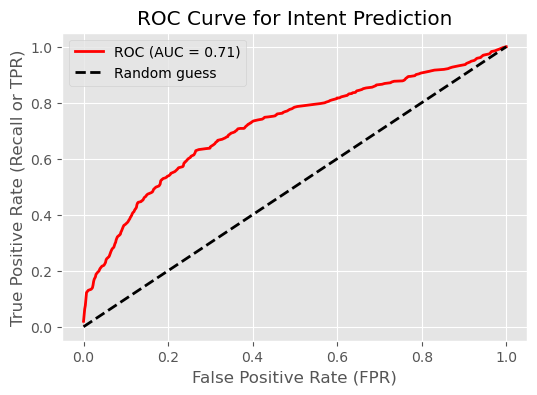

In [45]:
# probabilistic prediction
y_test_proba = logistic_model.predict_proba(X_matrix_test)[:,1] 

# ROC arrays
fprs, tprs, thresholds = roc_curve(y_test, y_test_proba)

# AUC
roc_auc = roc_auc_score(y_test, y_test_proba)

# plot
plt.figure()
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')  # Corrected line
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')  # Corrected line and added linestyle for clarity

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.title('ROC Curve for Intent Prediction')
plt.legend(loc='best')
plt.show()

Train set accuracy after SMOTE 0.81
Test set accuracy after SMOTE 0.62
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       712
           1       0.46      0.60      0.52       377

    accuracy                           0.62      1089
   macro avg       0.60      0.61      0.60      1089
weighted avg       0.65      0.62      0.63      1089

Confusion Matrix after SMOTE:
[[445 267]
 [150 227]]


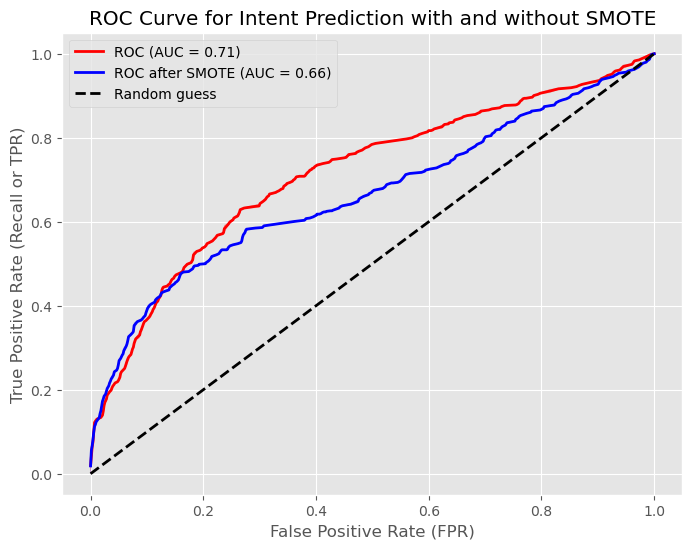

In [46]:
# Logreg with SMOTE

# Initialize the logistic regression model
logistic_model_sm = LogisticRegression(solver='liblinear', max_iter=10000)

# Fit the model on the SMOTE resampled training data
logistic_model_sm.fit(X_train_sm, y_train_sm)

# Evaluate the model on the original training set
print(f"Train set accuracy after SMOTE {logistic_model_sm.score(X_train_sm, y_train_sm):.2f}")

# Evaluate the model on the test set
print(f"Test set accuracy after SMOTE {logistic_model_sm.score(X_matrix_test, y_test):.2f}")

# Make predictions on the test set using the model trained on SMOTE data
test_predictions_sm = logistic_model_sm.predict(X_matrix_test)

# Print classification report
print("Classification Report after SMOTE:")
print(classification_report(y_test, test_predictions_sm))

# Print confusion matrix
print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, test_predictions_sm))

# Get probabilistic predictions
y_test_proba_sm = logistic_model_sm.predict_proba(X_matrix_test)[:,1]

# ROC arrays
fprs_sm, tprs_sm, thresholds_sm = roc_curve(y_test, y_test_proba_sm)

# AUC
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)

# Combined Plot
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})') # without SMOTE
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')

plt.title('ROC Curve for Intent Prediction with and without SMOTE')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.legend(loc='best')
plt.show()

* The SMOTE technique was applied to reduce imbalance in our dataset ebtween positive and negative classes.  Unfortunately, the SMOTE adjusted data did not result in a better result. Overall, the confidence of the model deteriorated compared to the baseline simple logistric regresison: macro avearges for all indicators (precision, recall, F1) have declined, and the overall test accuracy has declined, too.  

### Simple Logistic Regression - Coefficients

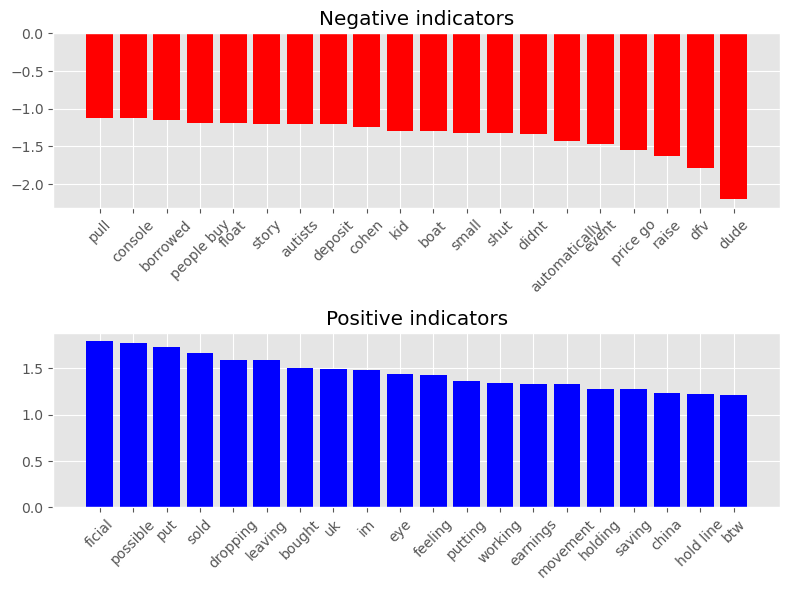

In [47]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients 
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

**Observation:**

* It is aleays useful to see the most important positive and negative word tokens coefficients.  
* Intention to buy stock is associated with words such as "bought", "holding", "morning", "tomorrow", "jumped".  However the positive list is full of words thatnormally do not necessarily show positive intentions to buy securities - many neutral words such as "portfolio", "theater" and even a contraindicating words such as "sold". This suggests that we dont have sufficient number of observations in our dataset. 
* We can see a similar picture with te negative coefficients, indicating lack of intention to buy: negative sentiment can be sensed in words such as "watch", "doubt", 'nah", "worthless". However, the list is full of neutral words such as "store", "yall", "situation", "result", "company", "business". 
* Overall, the review of coefficients suggests that the model has not been sufficiently trained to clearly distinguish positive and negative connotations. 

## 3.4. Gridsearch for logreg

* I use GridSearchCV to search over a specified parameter grid. 
* The GridSearch includes pre-processing steps: vectorisation, dimensionality reduction, logistical regression with various C-factors for regularisation. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [48]:
# Pipeline composition, includes preprocessing and the classifier
pipeline = Pipeline([
    #('scaler', StandardScaler(with_mean=False)),  
    #('scaler', StandardScaler()),
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),  # Vectorization
    #('svd', TruncatedSVD()),  # Dimensionality reduction
    ('logr', LogisticRegression(max_iter = 10000)) 
])

# Define the hyperparameters to search
param_grid = {
    'tfidf__max_df': [0.7], # this parameter allows to ignore words that appear in more than XX% of the documents. 
    'tfidf__tokenizer': [my_tokenizer], # also experimented with my_tokenizer, tokenizer_tweets, word_tokenize, TweetTokenizer
    'tfidf__ngram_range': [(1, 2)], # both unigrams and bigrams will be used as features
    #'svd__n_components': [400, 500], # reduce the feature space to the top XXX components
    'logr__C': [10, 100],
    'logr__solver': ['lbfgs'] # also tried liblinear solver which is good for small datasets
}

# Set up GridSearchCV to search for the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=0, n_jobs=-1)

# X_train on the raw text data
grid_search.fit(X_train, y_train)

# After fitting, get the best estimator
best_model = grid_search.best_estimator_

# Predict the test set using the best model
test_predictions = best_model.predict(X_test)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

In [49]:
# Calculate the accuracy
test_accuracy = accuracy_score(y_test, test_predictions)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Best hyperparameters: {'logr__C': 10, 'logr__solver': 'lbfgs', 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2), 'tfidf__tokenizer': <function my_tokenizer at 0x2850c3430>}
Test Accuracy: 0.7190
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       712
           1       0.61      0.51      0.56       377

    accuracy                           0.72      1089
   macro avg       0.69      0.67      0.68      1089
weighted avg       0.71      0.72      0.71      1089

Confusion Matrix:
[[591 121]
 [185 192]]


I used several different tokenizers in my gridsearch, all of them were coupled with the custom stop words list.  The best results are achieved with spaCy tokenisation. For some reason, my carefully designed tokenisation function did not perform as well. 

As a result, I use spaCy tokeniser throughout the rest of the workbook.  

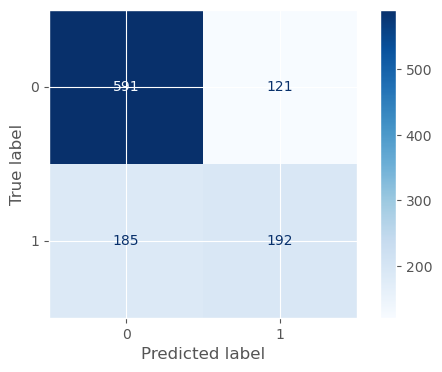

In [50]:
# Confusion matrix
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix with labels
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Model Interpretation:**

* The model has a high true negative rate of 0.89, meaning it is quite effective at identifying the negative cases correctly. 
* The false positive rate of relatively low at 0.11, meaning it doesn't frequently mislabel negative cases as positive.

* However, the true positive rate (Recall) is quite low at 0.40. This means that the model only correctly identifies 40% of the actual positive cases.
* The false negative rate is high at 0.60, indicating that 60% of the positive cases are missed by the model.

* The precision of 0.59 suggests that when the model predicts a case to be positive, it is correct 59% of the time. This is not high, and indicates there is sadly a significant proportion of false positives among the positive predictions.
* The F1 Score is 0.48. This relatively low score. The model is predicting positives only when very sure, and thus missing many actual positive cases.

* The model is cautious, with a tendency to predict negatives, which is likely because o fthe imbalance is data and teh small size of teh dataset. 
* This caution comes at the cost of missing a substantial number of true positives. 
* The model would benefit from adjustments to improve its recall without significantly sacrificing precision, perhaps through using the SMOTE (re-sampling the dataset), or exploring different models.

Below I am importing the best params into a pipeline for export into the big WSB dataset. 

In [51]:
# Importing the best parameters into the pipeline for further export to other notebooks
best_params = grid_search.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=best_params['tfidf__max_df'],
        tokenizer=best_params.get('tfidf__tokenizer'),  # Using 'get' for optional parameters
        ngram_range=best_params['tfidf__ngram_range'])),
    #('svd', TruncatedSVD(
    #    n_components=best_params['svd__n_components'])),
    ('logr', LogisticRegression(
        C=best_params['logr__C'], 
        solver=best_params['logr__solver']))
])

# Fit the best pipeline on the full training set
best_pipeline.fit(X_train, y_train)

# Best_pipeline predictions calculated 
test_predictions = best_pipeline.predict(X_test)

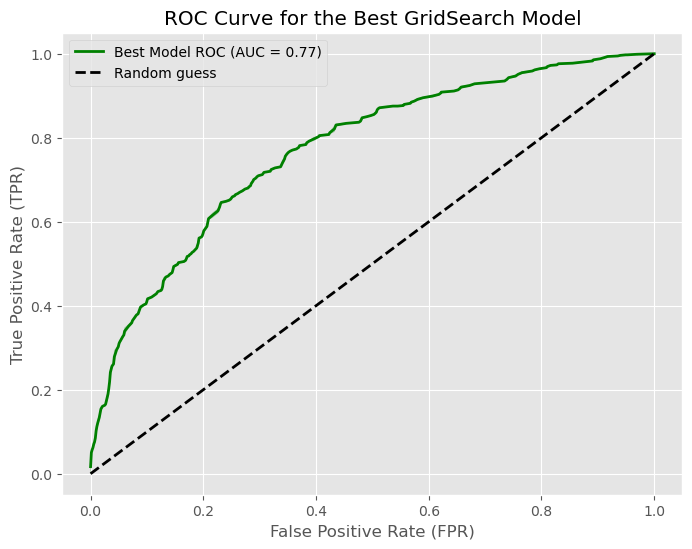

In [52]:
# Predict probabilities for the test set using best model
y_scores_best = best_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the best model
fprs_best, tprs_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_best = auc(fprs_best, tprs_best)

# Plot the ROC curve for the bext model 
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best, y=tprs_best, color='green', lw=2, label=f'Best Model ROC (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')
plt.title('ROC Curve for the Best GridSearch Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


####  Plot showing all logistical model regression ROC curves in one chart

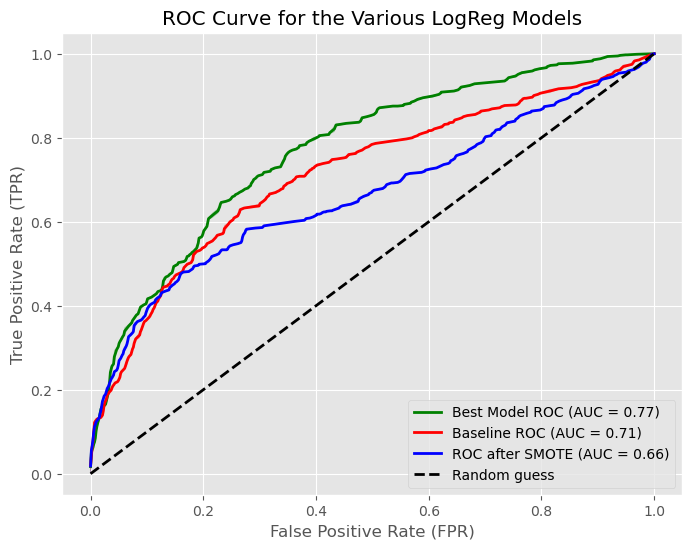

In [53]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best, y=tprs_best, color='green', lw=2, label=f'Best Model ROC (AUC = {roc_auc_best:.2f})') # best model
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'Baseline ROC (AUC = {roc_auc:0.2f})') # baseline
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')

# Customize the plot
plt.title('ROC Curve for the Various LogReg Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()

In [54]:
# Retraining my final model on the complete labeled dataset (all data available) before pickling it for future use:
# Fit the best pipeline on the full dataset
best_pipeline.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, ngram_range=(1, 2),
                                 tokenizer=<function my_tokenizer at 0x2850c3430>)),
                ('logr', LogisticRegression(C=10))])

In [55]:
import joblib

# Specify the file path and name for your pickled object
filename = '../model/03_A_best_pipeline_irrelevant.pkl'

# Save your model to a file
joblib.dump(best_pipeline, filename)

['../model/03_A_best_pipeline_irrelevant.pkl']

## 3.5. Decision Tree Classifier

### 3.5.1. Set up a pipeline

In [56]:
# PCA does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [57]:
# Create a pipeline with SVD and a decision tree classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stop_words)),  # Vectorization
    ('svd', TruncatedSVD()),                          # Dimensionality reduction
    ('clf', DecisionTreeClassifier())                 # Classifier
])

In [58]:
# Define the hyperparameters
param_grid = {
    'vect__max_df': [0.7, 0.8],
    'vect__ngram_range': [(1, 2)],
    'vect__tokenizer': [my_tokenizer],
    'svd__n_components': [100, 200],
    'clf__max_depth': [5],
    'clf__min_samples_split': [5],
    'clf__min_samples_leaf': [3]
}

### 3.5.2. Hyperparameter optimization

* I use GridSearchCV to search over a specified parameter grid. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [59]:
# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=0, n_jobs=-1)

In [60]:
# Run the grid search on DT 
grid_search.fit(X_train, y_train)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('svd', TruncatedSVD()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [5], 'clf__min_samples_leaf': [3],
                         'clf__min_samples_split': [5],
                         'svd__n_components': [100, 200],
                         'vect__max_df': [0.7, 0.8],
                         'vect__ngram_range': [(1, 2)],
                         'vect__tokenizer': [<function my_tokenizer at 0x2850c3430>]})

In [61]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'svd__n_components': 100, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 2), 'vect__tokenizer': <function my_tokenizer at 0x2850c3430>}


In [62]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_test)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.6896


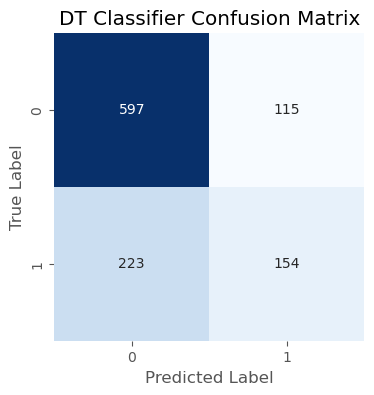

In [63]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DT Classifier Confusion Matrix')
plt.show()

In [64]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       712
           1       0.57      0.41      0.48       377

    accuracy                           0.69      1089
   macro avg       0.65      0.62      0.63      1089
weighted avg       0.67      0.69      0.67      1089



**DT model interpretation**

* The Decision Tree classifier's performance, after hyperparameter tuning and grid search, shows a moderate level of accuracy at 72%, which is lower than the previously constructed logistic regression model's accuracy of 78%. 
* While the model only slightly outperforms the baseline accuracy (majority class prediction is 0 with 73% frequency). The model's ability to classify the positive class (1s) is limited, with a precision of 46% and a notably low recall of 17%. This indicates that while the model is somewhat reliable in predicting the majority class (0s), with a high recall of 93%, it frequently misses the minority class (1s), leading to a substantial number of false negatives. 
* The f1-score for the positive class also shows that the model is conservative in predicting class 1s. 
* Overall, the model is not great at all.  

## 3.6. SVM

This section focuses on implementing a Support Vector Machine model for my dataset. 

The code snippets below are adapted from Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 300). O'Reilly Media. Kindle Edition. 

In [65]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(4354,)

In [66]:
print(y_test.shape)

(1089,)


In [67]:
# Standard Scaling does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [68]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1089, 1000)

First, let's try to fit a linear SVM model:

In [69]:
# Use StandardScaler with with_mean=False
svm_clf = make_pipeline(StandardScaler(with_mean=False),                        
                        LinearSVC(C=1, random_state=99, dual=False, max_iter=1000000))

# Fit the model
svm_clf.fit(X_matrix_train_dense, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearsvc',
                 LinearSVC(C=1, dual=False, max_iter=1000000,
                           random_state=99))])

In [70]:
cross_val_score(svm_clf, X_matrix_train, y_train).mean()

0.6917792997875345

Next, I am trying a more complex  polynomial model  to see if this helps to mporve accuracy:

In [71]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [72]:
cross_val_score(poly_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7032627314356599

The accuracy score improved a bit, but it is sitll not as high as some other models applied before.  
Let's try to fit a Radial Basis Function kernel: 

In [73]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="rbf", gamma=5, C=0.001))

rbf_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=0.001, gamma=5))])

In [74]:
cross_val_score(rbf_kernel_svm_clf, X_matrix_train, y_train).mean()

0.6534222785277854

The accuracy is not better with the RBF vector.  The polynomial kernel was a better choice.

Next, I will search for the best SVM model by optimising hyperparameters using gridsearch function:

In [75]:
svm_pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, tokenizer=my_tokenizer),
    SVC()
)

In [76]:
# Define the hyperparameters to search, including those for TF-IDF and SVM
param_grid = {
    'tfidfvectorizer__max_df': [0.7, 0.8],
    'tfidfvectorizer__ngram_range': [(1, 2)],
    'svc__kernel': ['poly'], # also tried 'rbf', 'linear'
    'svc__gamma': [0.1, 1, 10],
    'svc__C': [0.01, 0.1, 1],
    'svc__degree': [3, 4, 6],  # Only relevant for 'poly' kernel
    'svc__coef0': [5, 10, 20]   # Only relevant for 'poly' kernel
}

In [77]:
# Set up GridSearchCV
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

# Run the grid search on the raw text data
grid_search.fit(X_train, y_train)

# After fitting, get the best estimator and parameters
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
val_acc = accuracy_score(y_test, test_predictions)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.7291


In [ ]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'svc__C': 0.01, 'svc__coef0': 5, 'svc__degree': 3, 'svc__gamma': 1, 'svc__kernel': 'poly', 'tfidfvectorizer__max_df': 0.7, 'tfidfvectorizer__ngram_range': (1, 2)}


In [ ]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_test)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.7291


In [ ]:
print(X_matrix_test_dense.shape)
print(y_test.shape)

(1089, 1000)
(1089,)


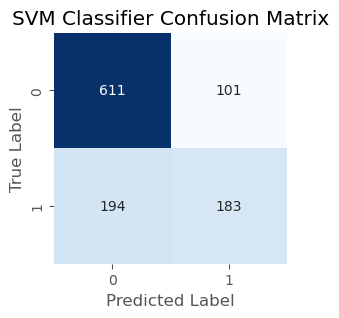

In [ ]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Classifier Confusion Matrix')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       712
           1       0.64      0.49      0.55       377

    accuracy                           0.73      1089
   macro avg       0.70      0.67      0.68      1089
weighted avg       0.72      0.73      0.72      1089



## 3.7. Random Forest Model

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=500)
random_forest_model.fit(X_matrix_train_dense, y_train)

RandomForestClassifier(n_estimators=500)

In [ ]:
# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_matrix_train_dense, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_matrix_test_dense, y_test))

In [ ]:
# Predictions on test data
y_pred = random_forest_model.predict(X_matrix_test_dense)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print all metrics
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_matrix_train_dense, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_matrix_test_dense, y_test)}
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
F1 Score: {f1}
Confusion Matrix: 
{conf_matrix}
""")


Performance on fitted data:
Average Decision Tree: 0.8664602664216813
Random Forest: 0.9947175011483693
----------------
Performance on test data:
Average Decision Tree: 0.6457722681359046
Random Forest: 0.7006427915518825
Accuracy: 0.7006427915518825
Precision: 0.6918050334840904
Recall: 0.7006427915518825
F1 Score: 0.694297707686611
Confusion Matrix: 
[[577 135]
 [191 186]]



In [ ]:
# Printing the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       712
           1       0.58      0.49      0.53       377

    accuracy                           0.70      1089
   macro avg       0.67      0.65      0.66      1089
weighted avg       0.69      0.70      0.69      1089



The random forest model performs quite well on the test set, better than the average of its component trees.

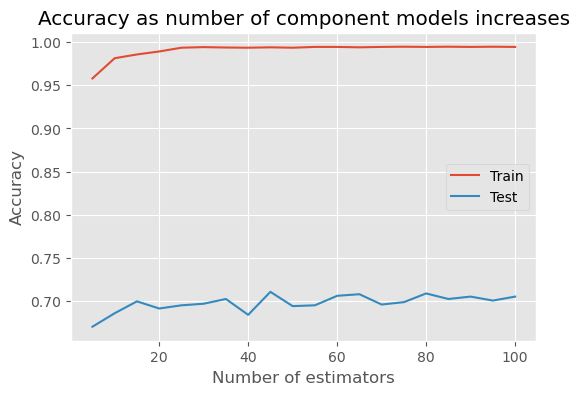

In [ ]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

Train set accuracy is improving until approximately 40 components, and stops improviing after that. Test set accuracy seems to be stable with minor variations past 20 components, but seems to be peaking at n=60.  

I will try to experiment with the depth of each tree in the code below:

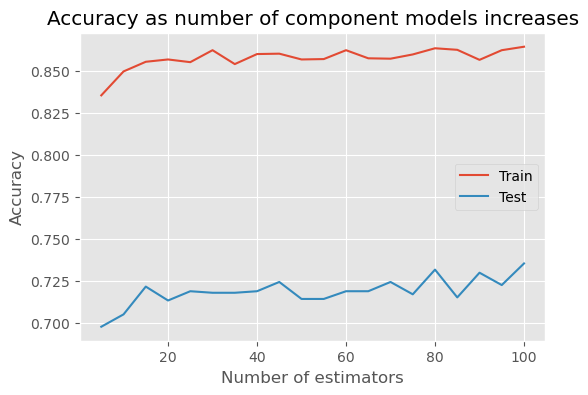

In [ ]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n,  max_depth =30)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

In [ ]:
# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=my_tokenizer, token_pattern=None)),  
    ('svd', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])

In [ ]:
# Define the parameter grid
param_grid = {
    'tfidf__tokenizer': [my_tokenizer],
    'svd__n_components': [200,300], 
    'clf__n_estimators': [60, 80, 83, 100],
    'clf__max_depth': [30],
    'clf__max_features': [20, 30, 40]
}

In [ ]:
# Create a grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=0, n_jobs=-1)

In [ ]:
# Run the grid search on Random Forest 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenizer at 0x15cfb93a0>)),
                                       ('svd', TruncatedSVD()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [30],
                         'clf__max_features': [20, 30, 40],
                         'clf__n_estimators': [60, 80, 83, 100],
                         'svd__n_components': [200, 300],
                         'tfidf__tokenizer': [<function my_tokenizer at 0x15cfb93a0>]})

In [ ]:
# Print the best hyperparameters for Random Forest Gridsearch
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

Best Parameters: {'clf__max_depth': 30, 'clf__max_features': 40, 'clf__n_estimators': 80, 'svd__n_components': 300, 'tfidf__tokenizer': <function my_tokenizer at 0x15cfb93a0>}
Best Score: 0.7225514338123705


In [ ]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       712
           1       0.65      0.30      0.41       377

    accuracy                           0.70      1089
   macro avg       0.68      0.61      0.60      1089
weighted avg       0.69      0.70      0.66      1089



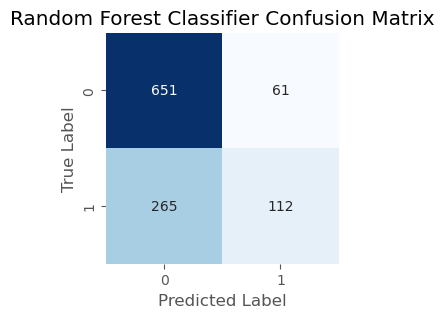

In [ ]:
# Corrected line for computing the confusion matrix
matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(3, 3))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Classifier Confusion Matrix')
plt.show()